### Notebook to compare ORCESTRA sounding statistics from different sources.

James Ruppert  
jruppert@ou.edu  
2/10/25

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from thermo_functions import *
import xarray as xr
import pandas as pd
from scipy import stats, signal
from bowtie_read_data import *
from time_series_diag import *
import seaborn as sns

### Read in data

#### Data from IPFS server

In [2]:
# GPS water vapor
path = "METEOR/GNSS_IWV.zarr"
var = "iwv"
cwv_gps, times_gps = get_ipfs_data(path, var)

# HALO dropsondes
snd_halo, times_halo = read_halo_soundings()
min_pres_halo = np.full(len(times_halo), np.nan)
for isnd in range(len(times_halo)):
    min_pres_halo[isnd] = np.nanmin(snd_halo['p'][isnd,:]*1e-2) # Pa --> hPa

# BCO soundings
snd_bco, times_bco = read_bco_soundings()
snd_desc_bco, times_bco_descent = read_bco_soundings(descent=True)
# Mask soundings that don't reach 100 hPa
snd_bco, min_pres_bco = mask_soundings(snd_bco, p_threshold=100)

#### Local data

In [3]:
# Soundings
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'ascen')
# RETAIN ACTUAL LAUNCH TIMES RATHER THAN EVEN THREE-HOURLY TIMES
search_string = 'ascen'
snd_files, times_snd = get_sounding_filelist(search_string=search_string)
soundings = read_soundings(snd_files)
snd_vars = list(soundings.keys())[2:] # retain only 2-d variables in list
# Mask soundings that don't reach 100 hPa
soundings, min_pres = mask_soundings(soundings, p_threshold=100)

# Radiometer data
cwv_rdm, times_rdm = read_bowtie_radiometer()

# Sun photometer data
photom = read_bowtie_sunphotometer()

# ERA5 IWV data
# alongtrack, alongsonde
cwv_era5v1, cwv_era5v2, times_era5, times_sonde_era5 = read_era5_shiptrack_iwv()

### Vertically integrate water vapor

In [4]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
# def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
#     rho = density_moist(tmpk, mr, p) # kg/m3
#     dz = hght[1]-hght[0] # m
#     invar_masked = np.copy(invar)
#     invar_masked[np.where(p < minpres)] = np.nan
#     var_int = np.nansum(invar_masked*rho, axis=1)*dz
#     # for iz in range(len(hght)):
#     #     print(snd_asc['p'][15,iz])
#     var_int[ np.where(np.isnan(soundings['p'][:,5])) ] = np.nan
#     return var_int
def vert_integral_hydro(data):
    p = data['p']
    try:
        sh = data['sh']
    except:
        sh = mixr2sh(data['mr'])
    var_int = -np.trapezoid(sh, p, axis=1)/9.81
    # Replace NaNs
    nans = np.where(np.isnan(p[:,5]))
    var_int[nans] = np.nan
    return var_int
def vert_integral(data):
    p = data['p']
    t = data['tmpk']
    hght = np.repeat(data['hght'][np.newaxis,:], p.shape[0], axis=0)
    try:
        sh = data['sh']
        mr = sh2mixr(sh)
    except:
        mr = data['mr']
        sh = mixr2sh(mr)
    # rho = density_moist(t, sh, p) # kg/m3
    rd=287.04
    rv=461.5
    eps_r=rv/rd
    rho = p / ( rd * t * (1. + mr*eps_r)/(1.+mr) )
    var_int = np.trapezoid(sh * rho, hght, axis=1)
    # Replace NaNs
    nans = np.where(np.isnan(p[:,5]))
    var_int[nans] = np.nan
    return var_int

# CWV aka IWV aka PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(soundings)
cwv_hydro = vert_integral_hydro(soundings)
cwv_halo = vert_integral(snd_halo)
cwv_halo_hydro = vert_integral_hydro(snd_halo)
cwv_bco = vert_integral(snd_bco)
# cwv_17m = vert_integral(soundings['mr'][:,2:], soundings['p'][:,2:], minpres=minpres) # mm or kg/m2

In [17]:
def vert_integral_mr(data):
    p = data['p']
    t = data['tmpk']
    hght = np.repeat(data['hght'][np.newaxis,:], p.shape[0], axis=0)
    try:
        sh = data['sh']
        mr = sh2mixr(sh)
    except:
        mr = data['mr']
        sh = mixr2sh(mr)
    # rho = density_moist(t, sh, p) # kg/m3
    rd=287.04
    rv=461.5
    eps_r=rv/rd
    rho = p / ( rd * t * (1. + mr*eps_r)/(1.+mr) )
    var_int = np.trapezoid(mr * rho, hght, axis=1)
    # Replace NaNs
    nans = np.where(np.isnan(p[:,5]))
    var_int[nans] = np.nan
    return var_int
cwv_mr = vert_integral_mr(soundings)

#### Helene's code

In [5]:
def q2vmr(q):
    import constants
    Md = constants.molar_mass_dry_air
    Mw = constants.molar_mass_water
    return q / ((1 - q) * Mw / Md + q)
def mr2vmr(mr):
    import constants
    Md = constants.molar_mass_dry_air
    Mw = constants.molar_mass_water
    return mr / (mr + Mw / Md)

def integrate_water_vapor(p, q, T=None, z=None, axis=0):
    """Returns the integrated water vapor for given specific humidity
    Args:
        p: pressure in Pa
        either: (hydrostatic)
            q: specific humidity
        or: (non-hydrostatic)
            q: specific humidity
            T: temperature
            z: height

    """

    def density(p, T, mr, eps=None):
        """
        returns density for given pressure, temperature and R
        """
        import constants
        Rd = constants.gas_constant_dry_air
        if eps is None:
            eps=18.0160/28.9660
            # eps = constants.eps1
        return eps * p * (1 + mr) / (Rd * T * (mr + eps))  # water vapor density

    def integrate_column(y, x, axis=0):
        if np.all(x[:-1] >= x[1:]):
            # return -np.trapz(y, x, axis=axis)
            return -np.trapezoid(y, x, axis=axis)
        else:
            # return np.trapz(y, x, axis=axis)
            return np.trapezoid(y, x, axis=axis)

    if T is None and z is None:
        # Calculate IWV assuming hydrostatic equilibrium.
        g = 9.81#constants.gravity_earth
        return -integrate_column(q, p, axis=axis) / g
    elif T is None or z is None:
        raise ValueError(
            "Pass both `T` and `z` for non-hydrostatic calculation of the IWV."
        )
    else:
        # Integrate the water vapor mass density for non-hydrostatic cases.
        Rv = 461.5  # J/kg/K
        # rho = density(p, T, constants.Rv)  # water vapor density
        rho = density(p, T, Rv)  # water vapor density
        # vmr = q2vmr(q)
        # vmr = q / ((1 - q) * constants.molar_mass_h2o / constants.md + q)
        vmr = q2vmr(q)

    return integrate_column(vmr * rho, z, axis=axis)

def get_cwv_helene(data):
    p = data['p']
    try:
        q = data['q']
    except:
        q = mixr2sh(data['mr'])
    T = data['tmpk']
    z = np.repeat(data['hght'][np.newaxis,:], p.shape[0], axis=0)
    return integrate_water_vapor(np.transpose(p), np.transpose(q), T=np.transpose(T), z=np.transpose(z), axis=0)

cwv_helene = get_cwv_helene(soundings)
cwv_halo_helene = get_cwv_helene(snd_halo)

---
### Plotting routines

#### Plotting functions

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

In [7]:
def plot_cwv_kde(legends, cwvs, title=''):

    sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    # sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")

    fig_x = 6
    fig_y = 4
    fig, ax = plt.subplots(1,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    plt.suptitle(title)
    ax.set_ylabel('Density')
    ax.set_xlabel('kg/m$^2$')

    default_colors = sns.color_palette()
    means = []

    for i, (icwv, legend) in enumerate(zip(cwvs, legends)):
        # Kernel Density Estimate (KDE) plots
        kde = sns.kdeplot(icwv, ax=ax, label=legend, fill=True, common_norm=True, color=default_colors[i])
        # Calculate the median values
        mean = np.nanmean(icwv)
        means.append(mean)
        # print("Mean: ", mean, 'kg/m^2')
        # Plot vertical lines at the median values
        lw = 1.0
        ax.axvline(x=mean, color=default_colors[i], linewidth=lw)

    ax.legend()
    return None

In [8]:
def plot_var_scatter(legends, vars_plot, xtitle='', title=''):

    sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    # sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")

    fig_x = 3
    fig_y = 4
    fig, ax = plt.subplots(1, 1, figsize=(fig_x, fig_y), layout='constrained', squeeze=True)
    plt.suptitle(title)
    ax.set_ylabel(xtitle)

    default_colors = sns.color_palette()

    # Plot raw CWV data
    for i, (ivar, legend) in enumerate(zip(vars_plot, legends)):
        ax.scatter(np.repeat(i, len(ivar)), ivar, label=legend, color=default_colors[i])

    # Set x-axis ticks and labels
    ax.set_xticks(range(len(legends)))
    ax.set_xticklabels(legends)

    # Adjust xlim to remove excess white space
    ax.set_xlim(-0.5, len(legends) - 0.5)

    plt.show()
    return None

In [9]:
def get_vars_skewt(sounding, it):
    from metpy.units import units
    from metpy.calc import dewpoint_from_specific_humidity
    p = sounding['p'][it,:].data * 1e-2
    T = (sounding['tmpk'][it,:].data - 273.15)
    try:
        sh = mixr2sh(sounding['mr'][it,:].data)
    except:
        sh = sounding['q'][it,:].data
    # Apply units for MetPy functions
    p *= units.hPa
    T *= units.degC
    sh *= units.dimensionless
    Td = dewpoint_from_specific_humidity(p, T, sh)
    return p, T, Td

In [10]:
def plot_sounding(sounding, t_ind, title=''):

    from metpy.plots import Hodograph, SkewT

    # sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")

    fig_x = 10
    fig_y = 7
    fig = plt.figure(figsize=(fig_x,fig_y), layout='constrained')

    skew = SkewT(fig, aspect=80)
    p, T, Td = get_vars_skewt(sounding, t_ind)
    skew.plot(p, T, 'r', linewidth=2)
    skew.plot(p, Td, 'g', linewidth=2)
    # skew.plot_barbs(p, u, v)

    # Add the relevant special lines
    # skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    # skew.plot_mixing_lines()
    # Set temperature range
    skew.ax.set_xlim(-40, 40)  # Adjust the temperature range as needed
    skew.ax.set_xlabel('T [$^\circ$C]')
    skew.ax.set_ylabel('P [hPa]')

    fig.suptitle(title)

    plt.show()

    return None

In [11]:
def plot_sounding_comparison(soundings_plot, t_ind, title):

    from metpy.plots import Hodograph, SkewT

    # sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
    sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
    # sns.set_theme(style="dark")

    fig_x = 10
    fig_y = 6
    fig = plt.figure(figsize=(fig_x,fig_y), layout='constrained')

    skew = SkewT(fig, aspect=110)

    # Add the relevant special lines
    # skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    # skew.plot_mixing_lines()

    # Set temperature range
    skew.ax.set_xlim(-40, 40)  # Adjust the temperature range as needed

    skew.ax.set_ylabel('P [hPa]')
    skew.ax.set_xlabel('T [$^\circ$C]')
    fig.suptitle(title)

    # for i, (i_sounding, i_t_ind) in enumerate(zip(soundings_plot, t_ind)):

    lw = 3.0
    p, T, Td = get_vars_skewt(soundings_plot[0], t_ind[0])
    skew.plot(p, T, 'r', linewidth=lw)
    skew.plot(p, Td, 'g', linewidth=lw)
    # skew.plot_barbs(p, u, v)

    lw = 1.0
    p, T, Td = get_vars_skewt(soundings_plot[1], t_ind[1])
    skew.plot(p, T, 'b', linewidth=lw, color='black')
    skew.plot(p, Td, 'c', linewidth=lw, color='black')
    # skew.plot_barbs(p, u, v)

    plt.show()
    return None

#### Compare integration approaches

In [12]:
# def vert_integral_old(invar, tmpk, mr, p, hght, minpres=0):
#     rho = density_moist(tmpk, mr, p) # kg/m3
#     dz = hght[1]-hght[0] # m
#     invar_masked = np.copy(invar)
#     invar_masked[np.where(p < minpres)] = np.nan
#     var_int = np.nansum(invar_masked*rho, axis=1)*dz
#     var_int[ np.where(np.isnan(soundings['p'][:,5])) ] = np.nan
#     return var_int
# def vert_integral_new(invar, p, minpres=0):
#     invar_masked = np.copy(invar)
#     invar_masked[np.where(p < minpres)] = np.nan
#     var_int = np.nansum(-invar_masked*np.gradient(p, axis=1), axis=1)/9.81
#     var_int[ np.where(np.isnan(soundings['p'][:,5])) ] = np.nan
#     return var_int

In [13]:
# cwv_zint_mr = vert_integral_old(soundings['mr'], soundings['tmpk'], soundings['mr'], soundings['p'],
#                     soundings['hght'], minpres=minpres) # mm or kg/m2
# mr = soundings['mr']
# sh = mr / (1 + mr)
# cwv_zint_sh = vert_integral_old(sh, soundings['tmpk'], soundings['mr'], soundings['p'],
#                     soundings['hght'], minpres=minpres) # mm or kg/m2
# cwv_pint_sh = vert_integral_new(sh, soundings['p'], minpres=minpres) # mm or kg/m2
# cwv_pint_mr = cwv

In [14]:
def mean_comparison(cwvs, legends):
    for i, icwv in enumerate(cwvs):
        print('Mean CWV for', legends[i], ':', np.nanmean(icwv).round(3), 'kg/m^2')
    print("Difference between means:" , np.abs(np.nanmean(cwvs[0]) - np.nanmean(cwvs[1])).round(3), 'kg/m^2')
    return None

Mean CWV for IWV-nonhyd : 57.454 kg/m^2
Mean CWV for IWV-hydro : 57.509 kg/m^2
Difference between means: 0.056 kg/m^2

Mean CWV for IWV-nonhyd : 50.682 kg/m^2
Mean CWV for IWV-hydro : 50.419 kg/m^2
Difference between means: 0.262 kg/m^2


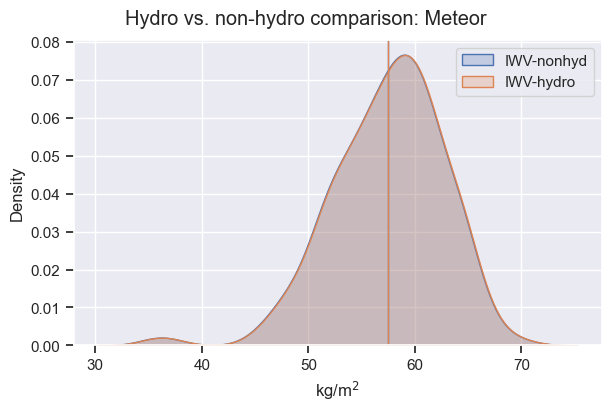

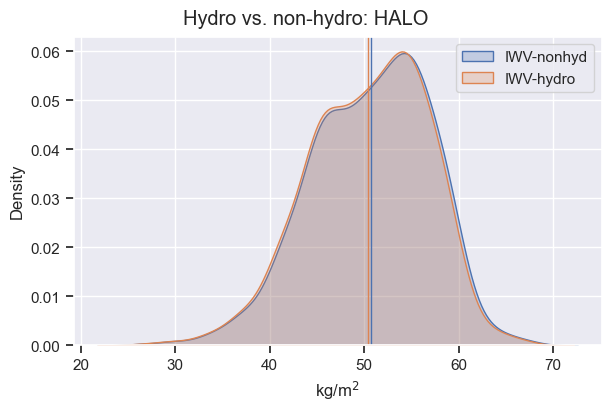

In [15]:
legends = ['IWV-nonhyd', 'IWV-hydro']
cwvs = [cwv, cwv_hydro]
plot_cwv_kde(legends, cwvs, title='Hydro vs. non-hydro comparison: Meteor')
mean_comparison(cwvs, legends)

print()

legends = ['IWV-nonhyd', 'IWV-hydro']
cwvs = [cwv_halo, cwv_halo_hydro]
plot_cwv_kde(legends, cwvs, title='Hydro vs. non-hydro: HALO')
mean_comparison(cwvs, legends)

Mean CWV for Using SH : 57.454 kg/m^2
Mean CWV for Using MR : 58.143 kg/m^2
Difference between means: 0.69 kg/m^2


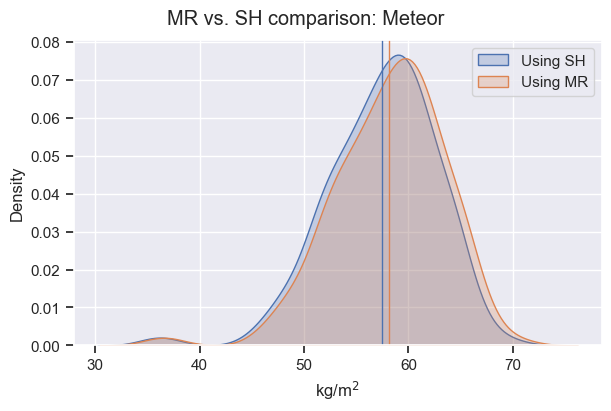

In [18]:
legends = ['Using SH', 'Using MR']
cwvs = [cwv, cwv_mr]
plot_cwv_kde(legends, cwvs, title='MR vs. SH comparison: Meteor')
mean_comparison(cwvs, legends)

Mean CWV for Using MR : 57.454 kg/m^2
Mean CWV for Using VMR : 57.496 kg/m^2
Difference between means: 0.043 kg/m^2

Mean CWV for Using MR : 50.682 kg/m^2
Mean CWV for Using VMR : 50.658 kg/m^2
Difference between means: 0.023 kg/m^2


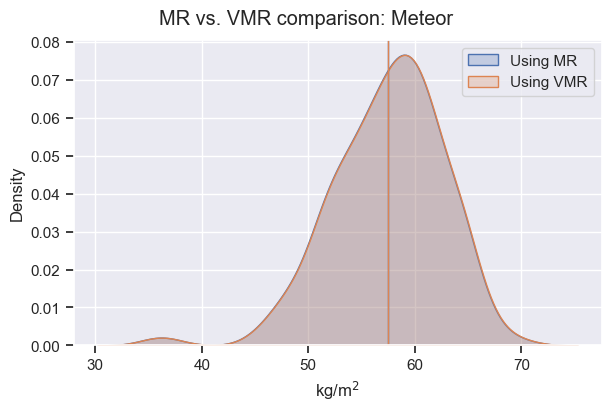

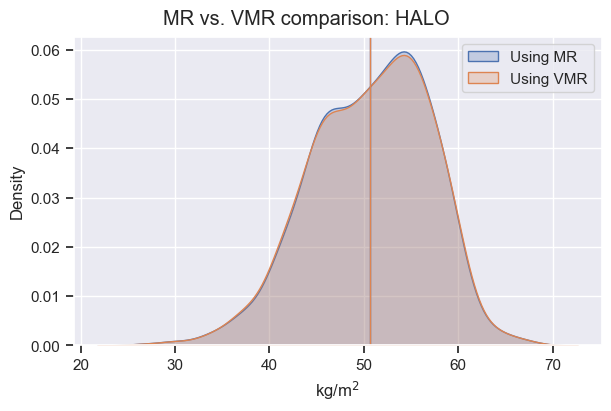

In [ ]:
legends = ['Using MR', 'Using VMR']
cwvs = [cwv, cwv_helene]
plot_cwv_kde(legends, cwvs, title='MR vs. VMR comparison: Meteor')
mean_comparison(cwvs, legends)

print()

legends = ['Using MR', 'Using VMR']
cwvs = [cwv_halo, cwv_halo_helene]
plot_cwv_kde(legends, cwvs, title='MR vs. VMR comparison: HALO')
mean_comparison(cwvs, legends)

Mean CWV for Using VMR : 50.658 kg/m^2
Mean CWV for FromData : 53.178 kg/m^2
Difference between means: 2.52 kg/m^2


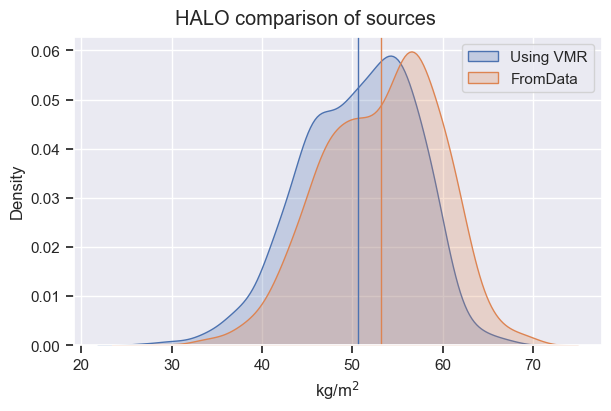

In [ ]:
legends = ['Using VMR', 'FromData']
cwvs = [cwv_halo_helene, snd_halo['iwv']]
plot_cwv_kde(legends, cwvs, title='HALO comparison of sources')
mean_comparison(cwvs, legends)

Median:  -1.96
Mean difference: -2.52 kg/m^2


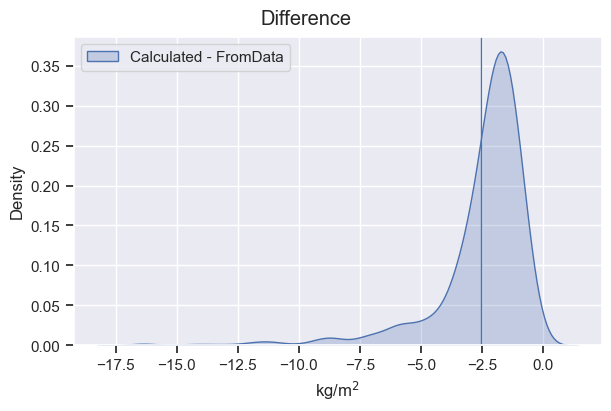

In [ ]:
legends = ['Calculated - FromData']
cwvs = [cwv_halo_helene - snd_halo['iwv']]
print("Median: ",np.median(cwvs).round(2))
plot_cwv_kde(legends, cwvs, title='Difference')
# mean_comparison(cwvs, legends)
print('Mean difference:', np.nanmean(cwvs).round(3), 'kg/m^2')

#### Exclude Mindelo data

In [ ]:
# Select times after 16 Aug 2024
t_start = np.datetime64('2024-08-16T08:00:00')
t_ind_snd = np.where(times_snd >= t_start)[0]
t_ind_rdm = np.where(times_rdm >= t_start)[0]
t_ind_photom = np.where(np.array(photom['Date(dd:mm:yyyy)']) >= t_start)[0]
t_ind_gps = np.where(times_gps >= t_start)[0]
t_ind_era5v1 = np.where(times_era5 >= t_start)[0]
t_ind_era5v2 = np.where(times_sonde_era5 >= t_start)[0]

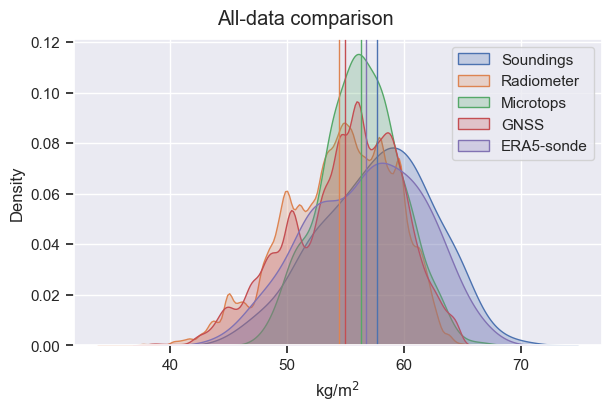

In [ ]:
cwvs = [
    cwv[t_ind_snd],
    # cwv_pint_sh[t_ind_snd],
    cwv_rdm[t_ind_rdm],
    photom['Water Vapor(cm)'][t_ind_photom],
    cwv_gps[t_ind_gps],
    # cwv_era5v1[t_ind_era5v1],
    cwv_era5v2[t_ind_era5v2],
]

legends = [
    'Soundings',
    # 'Soundings-SH',
    'Radiometer',
    'Microtops',
    'GNSS',
    # 'ERA5-track',
    'ERA5-sonde'
    ]

plot_cwv_kde(legends, cwvs, title='All-data comparison')

#### Compare two ERA5 datasets

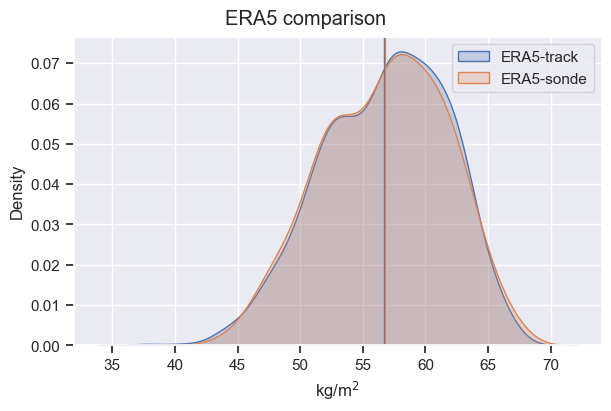

In [ ]:
legends = ['ERA5-track', 'ERA5-sonde']
cwvs = [cwv_era5v1[t_ind_era5v1], cwv_era5v2[t_ind_era5v2]]
plot_cwv_kde(legends, cwvs, title='ERA5 comparison')

#### Compare Meteor and HALO sondes

Mean CWV for Meteor : 57.454 kg/m^2
Mean CWV for HALO : 50.682 kg/m^2
Mean CWV for HALO-readIWV : 53.178 kg/m^2
Difference between means: 6.772 kg/m^2


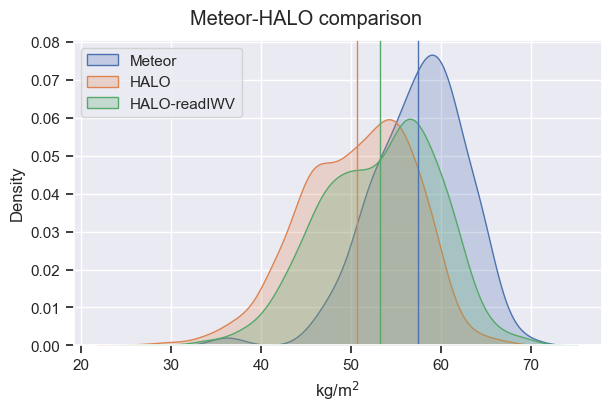

In [ ]:
legends = ['Meteor', 'HALO', 'HALO-readIWV']
cwvs = [cwv, cwv_halo, snd_halo['iwv']]
plot_cwv_kde(legends, cwvs, title='Meteor-HALO comparison')
mean_comparison(cwvs, legends)

#### Compare BCO and Meteor sondes

In [ ]:
# Select dates when Meteor was stationed next to BCO
# t_start = np.datetime64('2024-09-23T00:00:00')
t_start = np.datetime64('2024-09-22T20:00:00')
t_end = times_snd[-1]
# t_ind_snd = np.where((times_snd >= t_start) & (times_snd <= t_end))[0]
t_ind_bco_nearby = np.where((times_bco >= t_start) & (times_bco <= t_end))[0]
# print(times_snd[t_ind_snd])
# print(times_bco[t_ind_bco])

In [ ]:
# Identify matching times for Meteor and BCO within 1-hour window
t_ind_match = []
t_ind_bco = []
# delta = np.timedelta64(30, 'm') # 30 min
delta = np.timedelta64(60, 'm') # 60 min
# delta = np.timedelta64(90, 'm') # 60 min
for it in range(len(t_ind_bco_nearby)):
    t = times_bco[t_ind_bco_nearby[it]]
    t_ind = np.where((times_snd >= t - delta) & (times_snd <= t + delta))[0]
    if len(t_ind) > 0:
        # Check if nan
        if np.isnan(cwv[t_ind[0]]) or np.isnan(cwv_bco[t_ind_bco_nearby[it]]):
            continue
        t_ind_match.append(t_ind[0])
        t_ind_bco.append(t_ind_bco_nearby[it])
print(len(t_ind_match))

7


In [ ]:
mean_cwv = np.nanmean(cwv[t_ind_match])
mean_cwv_bco = np.nanmean(cwv_bco[t_ind_bco])
print("Mean CWV Meteor: ", mean_cwv.round(2), 'kg/m^2')
print("Mean CWV BCO: ", mean_cwv_bco.round(2), 'kg/m^2')

Mean CWV Meteor:  49.92 kg/m^2
Mean CWV BCO:  50.03 kg/m^2


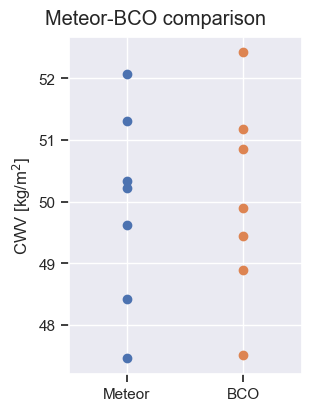

In [ ]:
legends = ['Meteor', 'BCO']
cwvs = [cwv[t_ind_match], cwv_bco[t_ind_bco]]
# cwvs = [cwv_17m[t_ind_match], cwv_bco[t_ind_bco]]
plot_var_scatter(legends, cwvs, xtitle='CWV [kg/m$^2$]', title='Meteor-BCO comparison')

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_16485/412405193.py:2: RuntimeWarning: All-NaN axis encountered
  p_max = np.nanmax(soundings['p'], axis=1)*1e-2
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_16485/412405193.py:3: RuntimeWarning: All-NaN axis encountered
  p_max_bco = np.nanmax(snd_bco['p'], axis=1)*1e-2


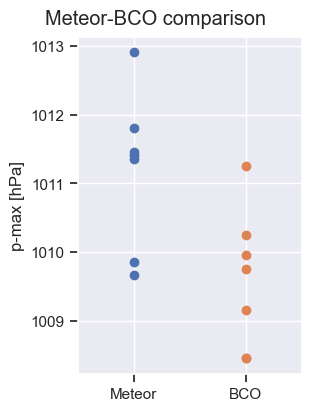

In [ ]:
# Get time series of maximum sounding pressure
p_max = np.nanmax(soundings['p'], axis=1)*1e-2
p_max_bco = np.nanmax(snd_bco['p'], axis=1)*1e-2

legends = ['Meteor', 'BCO']
pmax = [p_max[t_ind_match], p_max_bco[t_ind_bco]]
plot_var_scatter(legends, pmax, xtitle='p-max [hPa]', title='Meteor-BCO comparison')

#### Estimate the impact of BCO's elevation difference on CWV

In [ ]:
dp = np.mean(p_max[t_ind_match]) - np.mean(p_max_bco[t_ind_bco])
print('Mean pressure difference: ', dp, 'hPa')

q = 0.017 # kg/kg
g = 9.81 # m/s2
dp = dp*1e2 # hPa --> Pa
dq = q*dp/g
print('CWV difference: ', dq, 'kg/m2')

Mean pressure difference:  1.5958258928571922 hPa
CWV difference:  0.2765447520751505 kg/m2


#### Plot SkewTs

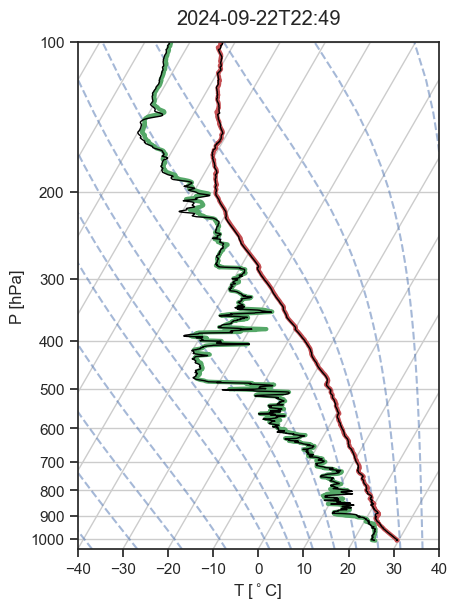

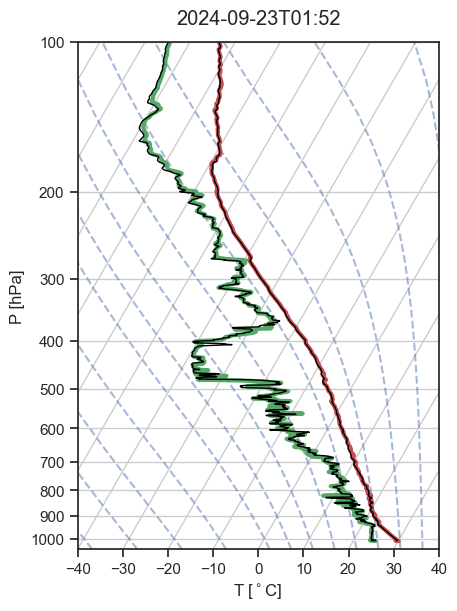

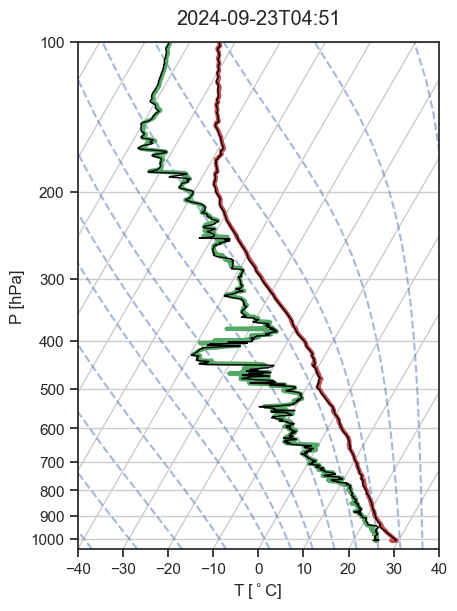

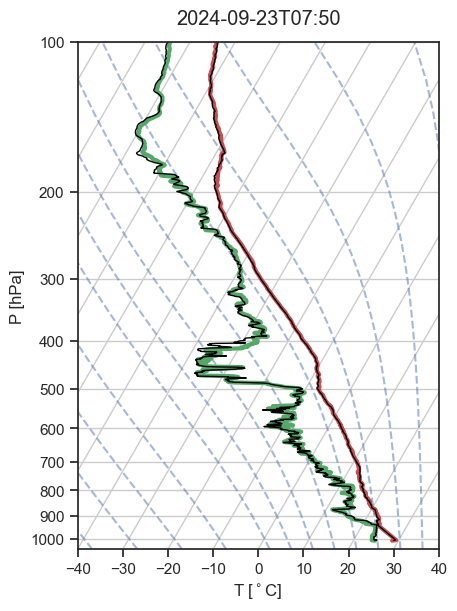

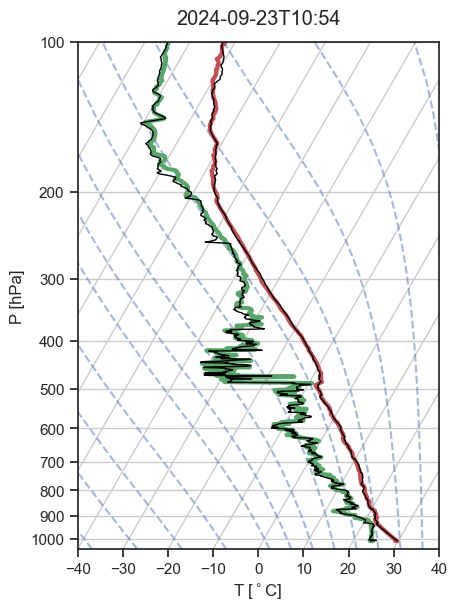

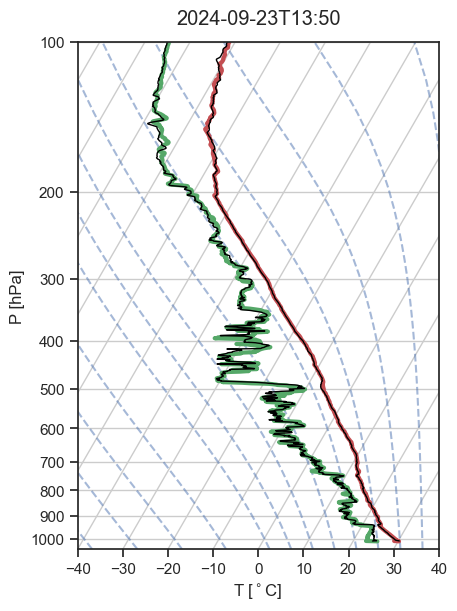

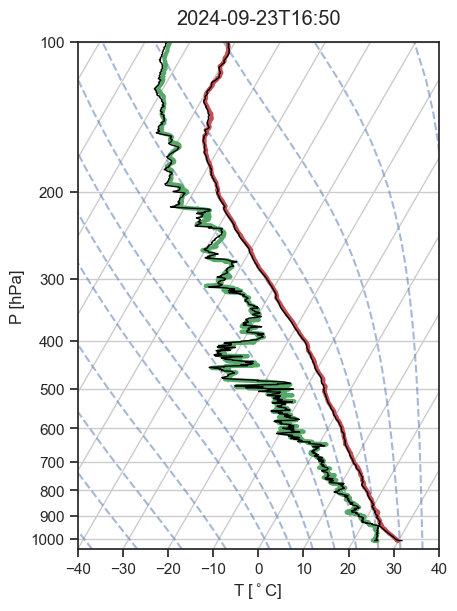

In [ ]:
legends = ['Meteor', 'BCO']
soundings_plot = [soundings, snd_bco]
# t_ind = [t_ind_match, t_ind_bco]
# times = [times_snd, times_bco]

# plot_sounding_comparison(soundings_plot, t_ind, times, legends)
for it in range(len(t_ind_match)):
# for it in range(1):

    # Meteor
    # snd_time = times_snd[t_ind_match[it]].astype('datetime64[m]').astype(str)
    # title = legends[0]+', '+snd_time
    # plot_sounding(soundings, t_ind_match[it], title)

    # # BCO
    # snd_time = times_bco[t_ind_bco[it]].astype('datetime64[m]').astype(str)
    # title = legends[1]+', '+snd_time
    # plot_sounding(snd_bco, t_ind_bco[it], title)

    snd_time = times_snd[t_ind_match[it]].astype('datetime64[m]').astype(str)
    title = snd_time
    t_ind = [t_ind_match[it], t_ind_bco[it]]
    plot_sounding_comparison(soundings_plot, t_ind, title)